# Kaggle Challange

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('sales.csv')

In [4]:
df.head(10)

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882
5,687329,674,2,2013-03-19,1016,1,1,0,0,8406
6,600327,659,7,2014-06-08,0,0,0,0,0,0
7,96265,27,3,2014-07-16,1106,1,1,0,1,11162
8,364435,347,6,2013-05-11,448,1,0,0,0,5559
9,163146,288,2,2013-06-25,291,1,0,0,0,3997


In [5]:
# No missing values:
df.isnull().sum()

Unnamed: 0             0
store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64

In [6]:
df.drop('Unnamed: 0',axis=1, inplace=True)

In [7]:
#The Idea was to look for the individual month and see if there is some correlation (e.g. Christmas)
# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract year and month into separate columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

df.drop('date',axis=1,inplace=True)

# 1 Cleaning and Transformation

In [8]:
# Checking if there are non-numeric values in the columns
non_numeric_rows = df[
    pd.to_numeric(df['nb_customers_on_day'], errors='coerce').isna() |
    pd.to_numeric(df['promotion'], errors='coerce').isna() |
    pd.to_numeric(df['state_holiday'], errors='coerce').isna() |
    pd.to_numeric(df['school_holiday'], errors='coerce').isna()
]

#I excluded a / b / c in the state holiday column. WIth more time I would have tried to figure out what the specific meaning of these strings are.
df = df[~df['state_holiday'].isin(['a', 'b', 'c'])]

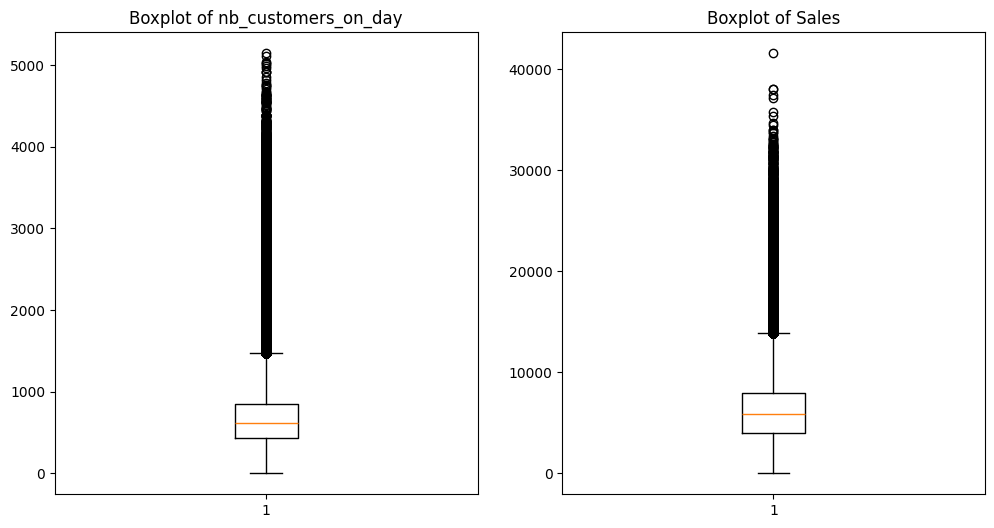

In [9]:
# checking for outlier: 
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
plt.figure(figsize=(12, 6))

# Boxplot for nb_customers_on_day
plt.subplot(1, 2, 1)
plt.boxplot(df['nb_customers_on_day'])
plt.title('Boxplot of nb_customers_on_day')

# Boxplot for sales
plt.subplot(1, 2, 2)
plt.boxplot(df['sales'])
plt.title('Boxplot of Sales')

plt.show()


In [10]:

# instead of deleting the outliers I tried to cap them:
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values below the lower bound to the lower bound, and values above the upper bound to the upper bound
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    
    return df

# Cap outliers for nb_customers_on_day
df = cap_outliers_iqr(df, 'nb_customers_on_day')

# Cap outliers for sales
df = cap_outliers_iqr(df, 'sales')

In [11]:
#In the end I did not delete the 0 outliers as it did not improve my model
#It looks like there are a significant number of outliers in the dataset:
#df = df[df['open']!=0]
# Function to cap outliers


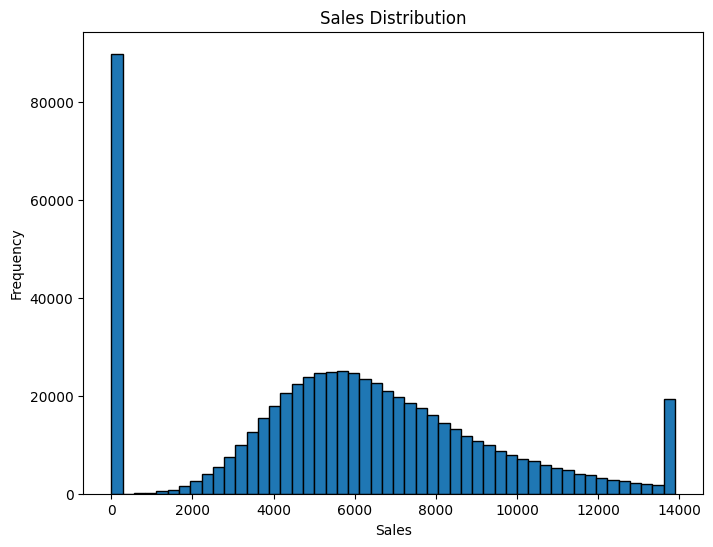

In [12]:
df.sales.describe()
import matplotlib.pyplot as plt

# Plot the histogram of sales
plt.figure(figsize=(8, 6))
plt.hist(df['sales'], bins=50, edgecolor='black')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


sales                  1.000000
nb_customers_on_day    0.914626
open                   0.688810
promotion              0.491188
school_holiday         0.139711
month                  0.048769
year                   0.027523
store_ID               0.003245
day_of_week           -0.522333
state_holiday               NaN
Name: sales, dtype: float64


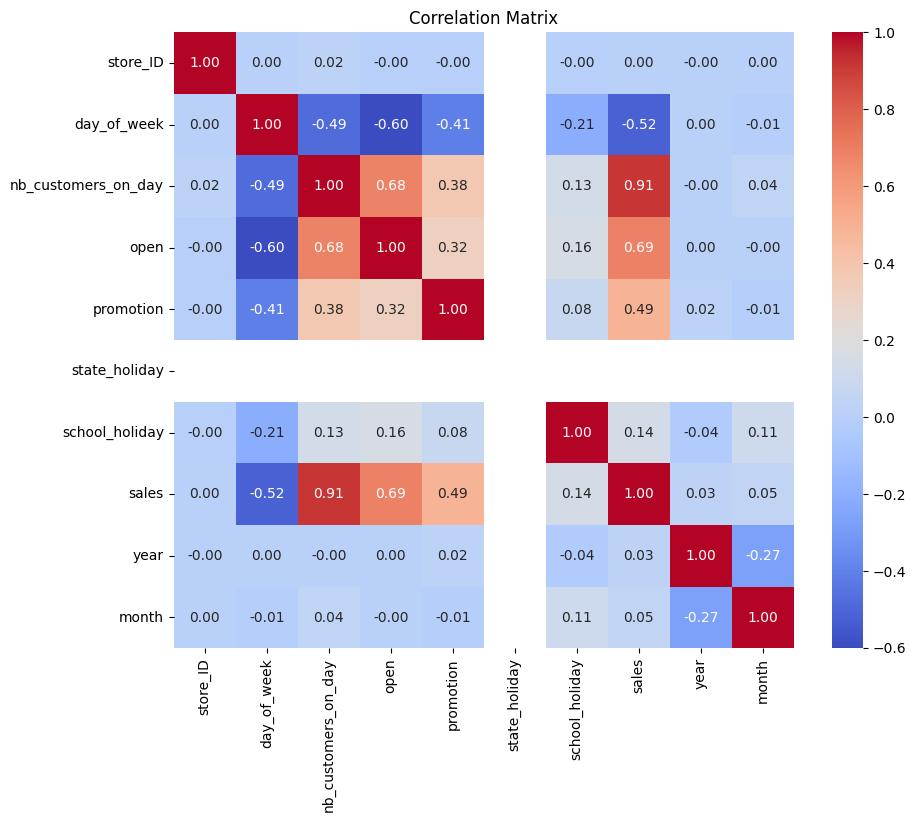

In [13]:
#Here I did a correlation matrix to get the relations between the columns
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df.corr()


print(correlation_matrix['sales'].sort_values(ascending=False))

# Optional: Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [14]:
# based on the heatmap I created new columns that basically combined the most important columns.
df['promotion_day_of_week'] = df['promotion'] * df['day_of_week']


df['open_promotion'] = df['open'] * df['promotion']

print(df[['promotion', 'day_of_week', 'promotion_day_of_week', 'open', 'open_promotion']].head())


   promotion  day_of_week  promotion_day_of_week  open  open_promotion
0          0            4                      0     1               0
1          0            6                      0     1               0
2          1            4                      4     1               1
3          1            2                      2     1               1
4          1            4                      4     1               1


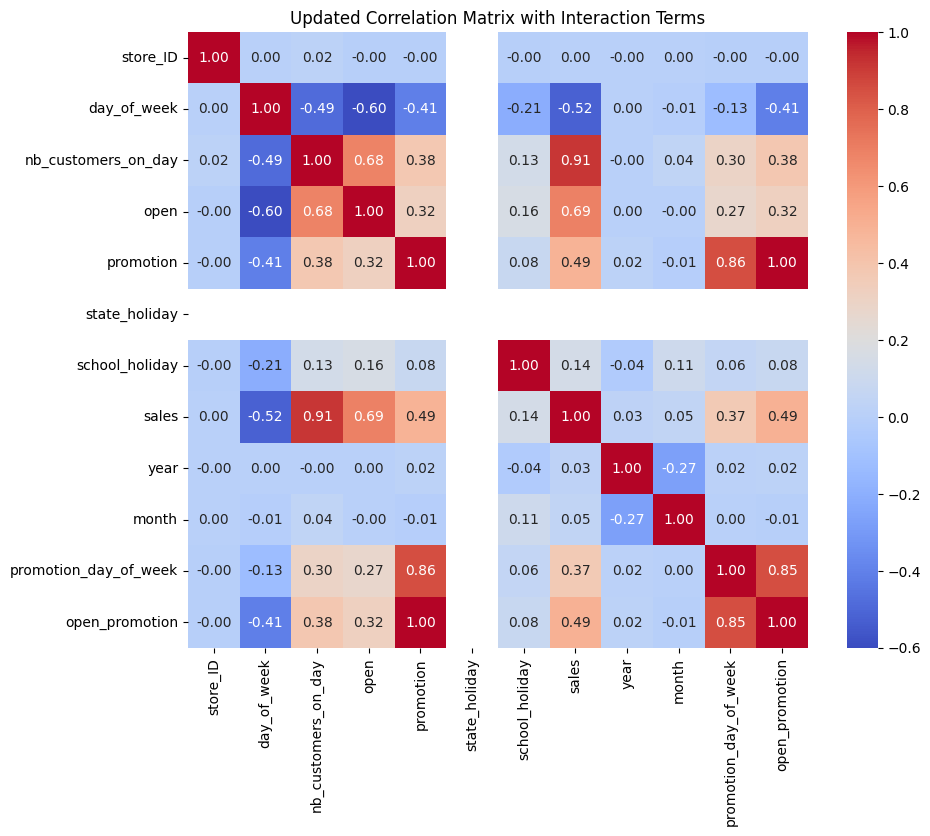

In [15]:
# Recalculate the correlation matrix with the new interaction terms
correlation_matrix = df.corr()

# Plot the new correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Updated Correlation Matrix with Interaction Terms")
plt.show()


# 2 Model Building

based on the training dataset and the newly created columns I tested several models

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the updated features including interaction terms
X = df[['nb_customers_on_day', 'open_promotion']]
y = df['sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)



## 2.1. Random Forest

In [17]:

from sklearn.ensemble import RandomForestRegressor
# Initialize the Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=12)

# Train the model
rf_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_reg.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")

Random Forest Mean Squared Error: 1616297.3080192355
Random Forest R^2 Score: 0.867759351683577


## 2.2 KMeans

In [24]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

# Define the features to cluster on
X = df[['nb_customers_on_day', 'open_promotion']]
y = df['sales']

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=12)
X['cluster'] = kmeans.fit_predict(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Use the cluster labels as a feature in the regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict on the test set
y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)

# Print the R-squared result
print(f"R-squared: {r2:.4f}")

R-squared: 0.8602


/var/folders/t3/8kjgwj5916lcv_26jt1s3fg80000gn/T/ipykernel_82532/3009283591.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = kmeans.fit_predict(X)


# Descision Tree

In [20]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=12)

# Train the model on the training data
tree_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = tree_reg.predict(X_test)

# Evaluate the model
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f"Decision Tree Mean Squared Error: {mse_tree}")
print(f"Decision Tree R^2 Score: {r2_tree}")


Decision Tree Mean Squared Error: 1616328.7754304893
Decision Tree R^2 Score: 0.8677567771133885


# Linear Regression:

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
lin_reg = LinearRegression()

# Train the model on the training data
lin_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_lin = lin_reg.predict(X_test)

# Evaluate the model
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print(f"Linear Regression Mean Squared Error: {mse_lin}")
print(f"Linear Regression R^2 Score: {r2_lin}")


Linear Regression Mean Squared Error: 1709223.066465195
Linear Regression R^2 Score: 0.8601564419458577


## DBSCAN (Clustering)

In [123]:
## I could not run a DBSCAN because it computed for too long

#from sklearn.cluster import DBSCAN
#from sklearn.preprocessing import StandardScaler

# Standardize the features (important for DBSCAN)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Apply DBSCAN clustering
#dbscan = DBSCAN(eps=0.5, min_samples=5)
#df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# Analyze the clusters
#print(df['dbscan_cluster'].value_counts())


In [ ]:
print('the R^2 Score for the Decision Tree and the Random Forest were the higest')